# Chapter #
This notebook is complementary material to Chapter #. of the thesis.

# The Guardian Opem platformm API
- https://open-platform.theguardian.com
- Price data is taken from yahoo finance.
- Idea of visualization is inspired by https://github.com/janlukasschroeder/netflix-stock-price-impacted-by-news

In [66]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:
import os
from dotenv import load_dotenv

load_dotenv()

# Contact me for the API key
THE_GUARDIAN_API_KEY = os.getenv("THE_GUARDIAN_API_KEY")

In [68]:
from datetime import datetime

YEAR = 2024

quarters = {
    "Q1": {"start": datetime(YEAR, 1, 1).date(), "end": datetime(YEAR, 3, 31).date()},
    "Q2": {"start": datetime(YEAR, 4, 1).date(), "end": datetime(YEAR, 6, 30).date()},
    "Q3": {"start": datetime(YEAR, 7, 1).date(), "end": datetime(YEAR, 9, 30).date()},
    "Q4": {"start": datetime(YEAR, 10, 1).date(), "end": datetime(YEAR, 12, 31).date()},
    "TEST": {"start": datetime(YEAR, 9, 15).date(), "end": datetime(YEAR, 9, 25).date()},
}

# Access the concrete quarter
quarter = quarters["Q3"]

print(f"START:   {quarter['start']} \nEND:     {quarter['end']}")

START:   2024-07-01 
END:     2024-09-30


In [69]:
section = "section=(business|technology|politics|international)"
from_date = f"from-date={quarter['start']}"
to_date = f"to-date={quarter['end']}"
order_by = "order-by=oldest"
use_date = "use-date=published"
show_references = "show-references=reuters-stock-ric"
page_size = "page-size=200"
query = "q=Boeing"
api_key = f"api-key={THE_GUARDIAN_API_KEY}"

query_string = f"{section}&{from_date}&{to_date}&{order_by}&{show_references}&{page_size}&{query}"
api = f"https://content.guardianapis.com/search?{query_string}&{api_key}"

In [70]:
import requests
import time 

try:    
    response = requests.get(api)
    json_response = response.json()

    pages = json_response['response']['pages']

    articles = json_response['response']['results']

    for page in range(2, pages+1):
        time.sleep(1) # to avoid rate limiting
        api = f"https://content.guardianapis.com/search?{query_string}&page={page}&{api_key}"
        response = requests.get(api)
        json_response = response.json()
        articles += json_response['response']['results']

except requests.exceptions.HTTPError as errh:
    print ("Http Error:",errh)
except requests.exceptions.ConnectionError as errc:
    print ("Error Connecting:",errc)
except requests.exceptions.Timeout as errt:
    print ("Timeout Error:",errt)
except requests.exceptions.RequestException as e: 
    raise SystemExit(e) 

print(len(articles))

36


In [71]:
# Get Apple Inc. (AAPL) stock data

import yfinance as yf

_start = from_date.split("=")[1]
_end = to_date.split("=")[1]

quotes = yf.download("BA", rounding=True, start=_start, end=_end)
display(quotes)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-01,182.20,189.47,182.20,186.70,186.70,9056700
2024-07-02,186.34,189.23,184.52,185.42,185.42,4110500
2024-07-03,185.05,185.42,182.85,184.31,184.31,2764800
2024-07-05,184.00,185.38,182.23,184.83,184.83,3290400
2024-07-08,186.94,191.50,182.28,185.84,185.84,9878100
...,...,...,...,...,...,...
2024-09-23,153.00,158.43,151.65,156.30,156.30,12476800
2024-09-24,155.80,155.90,153.69,155.81,155.81,7414900
2024-09-25,156.42,157.22,152.04,152.22,152.22,9587700


In [72]:
import pandas as pd
from typing import Dict
from datetime import datetime

# Get news volume for each day
def get_news_volume(articles, quotes) -> Dict:
    news_volume = {}
    for article in articles:
        date_str = article['webPublicationDate'].split("T")[0]
        date = pd.Timestamp(datetime.strptime(date_str, '%Y-%m-%d').date())
        if date in news_volume:
            news_volume[date] += 1
        else:
            news_volume[date] = 1
        # Make sure that the news volume dictionary has an entry for each day
    for date in quotes.index:
        news_volume[date] = news_volume[date] if date in news_volume else 0

    news_volume = dict(sorted(news_volume.items()))
    
    return news_volume
    

In [73]:
news_volume = get_news_volume(articles, quotes)
for date, volume in news_volume.items():
    print(f"{date} | {volume} | {date.strftime('%A')}")  
    

2024-07-01 00:00:00 | 2 | Monday
2024-07-02 00:00:00 | 0 | Tuesday
2024-07-03 00:00:00 | 1 | Wednesday
2024-07-05 00:00:00 | 0 | Friday
2024-07-08 00:00:00 | 3 | Monday
2024-07-09 00:00:00 | 1 | Tuesday
2024-07-10 00:00:00 | 0 | Wednesday
2024-07-11 00:00:00 | 0 | Thursday
2024-07-12 00:00:00 | 0 | Friday
2024-07-15 00:00:00 | 1 | Monday
2024-07-16 00:00:00 | 0 | Tuesday
2024-07-17 00:00:00 | 0 | Wednesday
2024-07-18 00:00:00 | 1 | Thursday
2024-07-19 00:00:00 | 0 | Friday
2024-07-21 00:00:00 | 1 | Sunday
2024-07-22 00:00:00 | 0 | Monday
2024-07-23 00:00:00 | 0 | Tuesday
2024-07-24 00:00:00 | 0 | Wednesday
2024-07-25 00:00:00 | 0 | Thursday
2024-07-26 00:00:00 | 0 | Friday
2024-07-27 00:00:00 | 1 | Saturday
2024-07-29 00:00:00 | 1 | Monday
2024-07-30 00:00:00 | 1 | Tuesday
2024-07-31 00:00:00 | 3 | Wednesday
2024-08-01 00:00:00 | 1 | Thursday
2024-08-02 00:00:00 | 0 | Friday
2024-08-05 00:00:00 | 0 | Monday
2024-08-06 00:00:00 | 0 | Tuesday
2024-08-07 00:00:00 | 0 | Wednesday
2024-08-0

In [74]:
quotes['News Volume'] = 0

temp_volume = 0

for date, volume in news_volume.items():
    if date in quotes.index:
        # Add the volume of the current day and the volume of the previous days not in quotes
        quotes.loc[date, 'News Volume'] = volume + temp_volume
        temp_volume = 0
    else:
        # Accumulate the volume of the days not in quotes
        temp_volume += volume

# Convert 'News Volume' to integer type
quotes['News Volume'] = quotes['News Volume'].astype(int)        

In [75]:
display(quotes)

,Open,High,Low,Close,Adj Close,Volume,News Volume
Date,,,,,,,
2024-07-01,182.20,189.47,182.20,186.70,186.70,9056700,2
2024-07-02,186.34,189.23,184.52,185.42,185.42,4110500,0
2024-07-03,185.05,185.42,182.85,184.31,184.31,2764800,1
2024-07-05,184.00,185.38,182.23,184.83,184.83,3290400,0
2024-07-08,186.94,191.50,182.28,185.84,185.84,9878100,3
...,...,...,...,...,...,...,...
2024-09-23,153.00,158.43,151.65,156.30,156.30,12476800,0
2024-09-24,155.80,155.90,153.69,155.81,155.81,7414900,2
2024-09-25,156.42,157.22,152.04,152.22,152.22,9587700,1


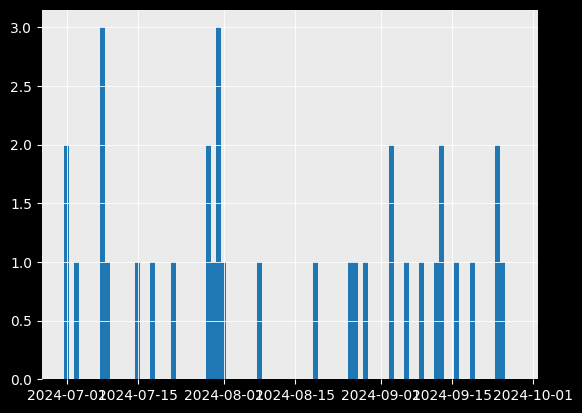

In [76]:
import matplotlib.pyplot as plt

# Set ggplot styles and update Matplotlib with them.
ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'white',
    'grid.linewidth': '0.6',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.major.left': True,
    'ytick.minor.left': False,
}

plt.rcParams.update(ggplot_styles)

plt.bar(quotes.index, quotes['News Volume'], width=1)
plt.show()

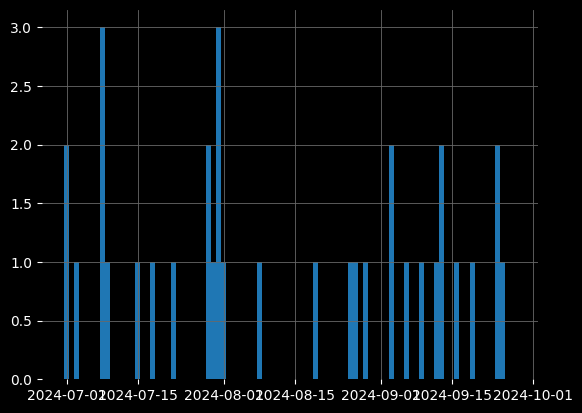

In [77]:
import matplotlib.pyplot as plt

# Set ggplot styles and update Matplotlib with them.
ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'white',
    'grid.linewidth': '0.6',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.major.left': True,
    'ytick.minor.left': False,
}

ggplot_styles = {
    'axes.edgecolor': 'dimgray',
    'axes.facecolor': '000000',  # Change background color to black
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'dimgray',  # Ensure grid lines are visible on black background
    'grid.linewidth': '0.6',
    'xtick.color': 'white',  # Ensure x-tick labels are visible
    'ytick.color': 'white',  # Ensure y-tick labels are visible
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.major.left': True,
    'ytick.minor.left': False,
    'text.color': 'white',  # Ensure text is visible
    'axes.labelcolor': 'white',  # Ensure axis labels are visible
    'figure.facecolor': '000000',  # Change figure background color to black
}

plt.rcParams.update(ggplot_styles)

plt.bar(quotes.index, quotes['News Volume'], width=1)
plt.show()

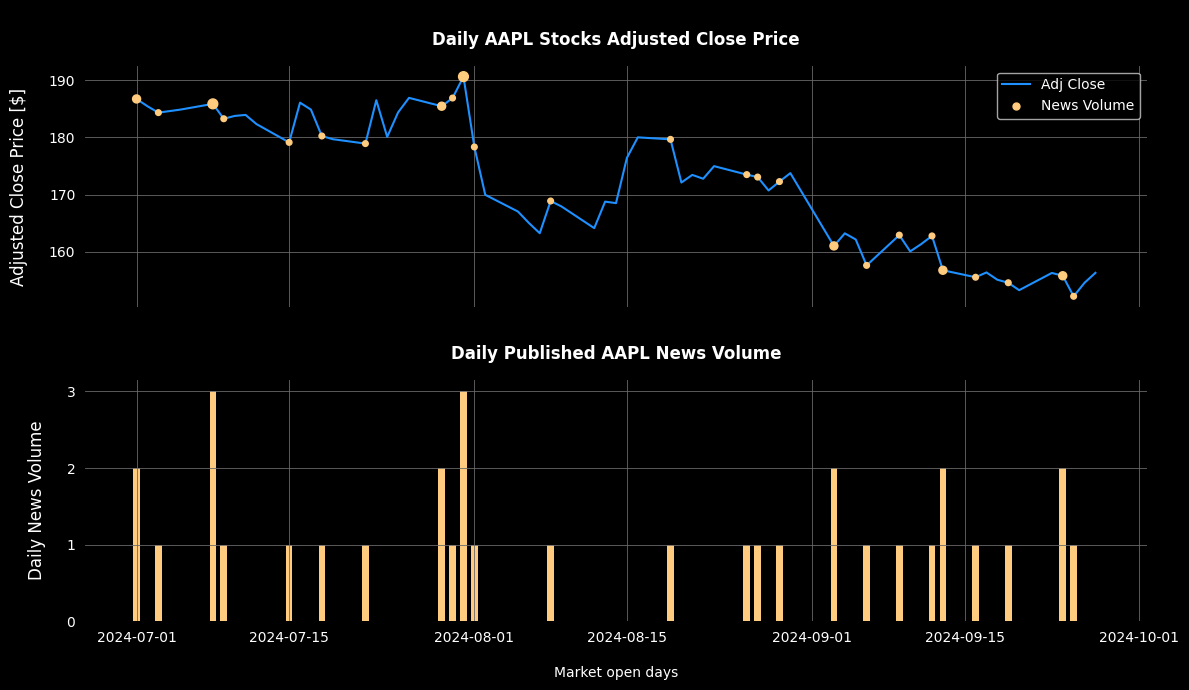

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set the style of the plot
#plt.style.use('ggplot')
plt.rcParams.update(ggplot_styles)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

# Plot the adjusted close prices
ax1.set_title('\nDaily AAPL Stocks Adjusted Close Price', pad=15, weight='bold')
ax1.set_ylabel(r'Adjusted Close Price [$]', labelpad=15, fontsize='large')
ax1.plot(quotes.index.to_numpy(), quotes['Adj Close'].to_numpy(), label='Adj Close', color='dodgerblue')
ax1.grid(True)
ax1.tick_params(bottom=False, left=False)

# Normalize the news volume for marker size
max_news_volume = quotes['News Volume'].max()
normalized_news_volume = (quotes['News Volume'] / max_news_volume) * 50

# Plot the news volume as red dots on the price chart
ax1.scatter(quotes.index, quotes['Adj Close'], label='News Volume', color='#FFCB7E', s=normalized_news_volume, zorder=2)

# Plot the news volume as a bar chart
ax2.set_title('Daily Published AAPL News Volume', pad=15, weight='bold')
ax2.set_xlabel('Market open days', labelpad=15)
ax2.set_ylabel('Daily News Volume', labelpad=15, fontsize='large')
ax2.bar(quotes.index, quotes['News Volume'], width=0.6, color='#FFCB7E', zorder=1)
ax2.grid(True)
ax2.tick_params(bottom=False, left=False)

# Set the y-axis to display only integer values
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.legend()

# Adjust layout for better spacing
fig.tight_layout()

# Add space between ax1 and ax2
plt.subplots_adjust(hspace = 0.3)

# Save as pdf
plt.savefig('/Users/stiborv/Documents/NMgr/ZS2425/PROFINIT/news_volume.pdf', format='pdf')

plt.show()
